# [F-29] 사이킷런을 활용한 추천 시스템 입문

## 추천 시스템
> 사용자(user)에게 관련된 아이템(item)을 추천해주는 것

> - 범주형, 이산적인 데이터를 숫자 벡터로 변환하기
> - 이 숫자 벡터의 유사도를 계산해 유사도가 가까운 (or 높은) 제품을 추천해주기

## 1. 코사인 유사도
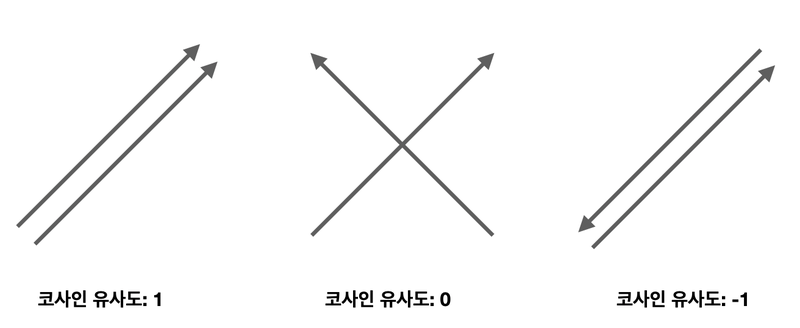

<br/>

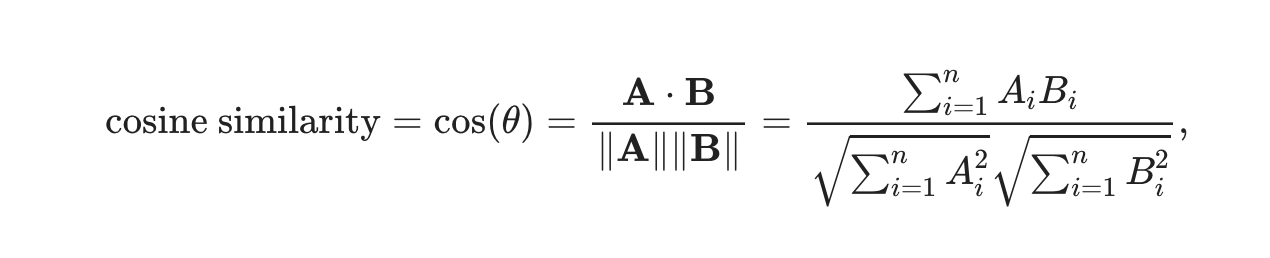

> **코사인 유사도(Cosine Similarity)** 는 두 벡터 간의 코사인 값을 이용해 두 벡터의 유사도를 계산한다.
> - **-1 ~ +1** 사이의 값이고, 1에 가까울 수록 유사도가 높다고 할 수 있다.

### - Numpy 활용

In [1]:
import numpy as np

t1 = np.array([1, 1, 1])
t2 = np.array([2, 0, 1])

In [3]:
from numpy import dot
from numpy.linalg import norm
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

In [4]:
cos_sim(t1, t2)

0.7745966692414834

### - 사이킷런 활용

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

# 해당 모듈은 입력값으로 2차원 배열을 받는다.
t1 = np.array([[1, 1, 1]])
t2 = np.array([[2, 0, 1]])
cosine_similarity(t1, t2)

array([[0.77459667]])

> 코사인 유사도 외에 유클리드 거리, 자카드 유사도, 피어슨 상관계수 등의 다른 방법으로 유사도를 계산할 수 있다.

## 2. 추천시스템의 종류

#### 콘텐츠 기반 필터링(Content Based Filtering)

#### 협업 필터링(Collaborative Filtering)
- 사용자 기반
- 아이템 기반
- 잠재요인 협업 필터링 (latent factor collaborative filtering) -> 행렬 인수분해 (matrix factorization)

#### Deep Learning 적용 or Hybrid 방식
- 딥러닝 등을 활용한 추천 방법
- 여러 방법을 결합한 하이브리드(Hybrid) 방법

여기선 **콘텐츠 기반 필터링**과 **협업 필터링**에 대해 알아보자.
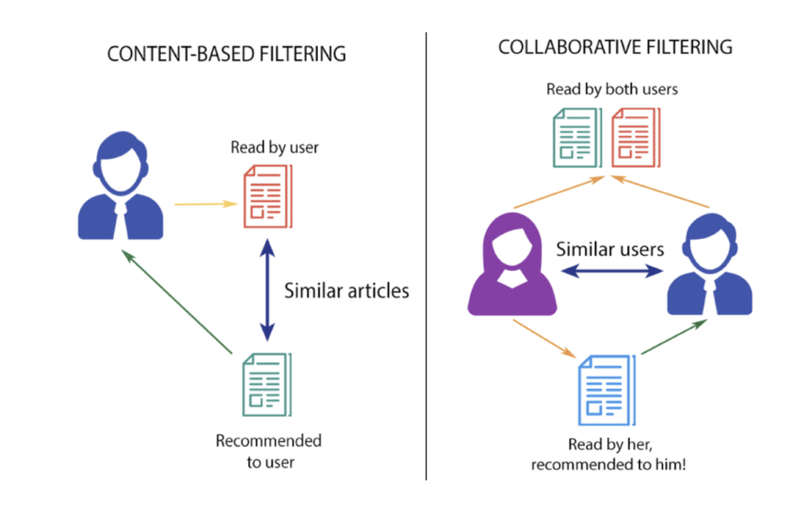

## 3. 콘텐츠 기반 필터링 (Content Based Filtering)

> 순수하게 콘텐츠의 내용만을 비교해 추천하는 방식
> - ex) 어떤 사람이 한 영화를 좋아한다고 하면, 비슷한 콘텐츠의 아이템 추천해주기

영화의 **특성(feature)** 이란 장르, 배우, 감독 등의 정보일 것이다.
- 이 특성들이 '콘텐츠'가 비슷하다고 말할 수 있는 요인들이다.

<br/>


### 콘텐츠 기반 필터링 실습

> 아래 예제는 CODE HEROKU의 https://www.codeheroku.com/post.html?name=Building%20a%20Movie%20Recommendation%20Engine%20in%20Python%20using%20Scikit-Learn 를 바탕으로 제작됨

### 1) 모듈 import

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### 2) Load 데이터
예제 데이터는 `movie_dataset`을 사용한다.

In [ ]:
# wget https://aiffelstaticprd.blob.core.windows.net/media/documents/movie_dataset.csv

In [7]:
import os
csv_path = os.getenv('HOME')+'/aiffel/movie_recommendation/movie_dataset.csv'
df = pd.read_csv(csv_path)
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [80]:
df.shape

(4803, 25)

### 3) 특성 선택

In [8]:
df.columns

Index(['index', 'budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'director'],
      dtype='object')

In [9]:
# 많은 컬럼 중 아래 특성만 고려해 영화 유사도를 계산해 추천해주자.
features = ['keywords', 'cast', 'genres', 'director']
features

['keywords', 'cast', 'genres', 'director']

In [10]:
def combine_features(row):
    return row['keywords']+" "+row['cast']+" "+row['genres']+" "+row['director']

combine_features(df[:5])

0    culture clash future space war space colony so...
1    ocean drug abuse exotic island east india trad...
2    spy based on novel secret agent sequel mi6 Dan...
3    dc comics crime fighter terrorist secret ident...
4    based on novel mars medallion space travel pri...
dtype: object

In [11]:
for feature in features:
    df[feature] = df[feature].fillna('')

df["combined_features"] = df.apply(combine_features, axis=1)
df["combined_features"]

0       culture clash future space war space colony so...
1       ocean drug abuse exotic island east india trad...
2       spy based on novel secret agent sequel mi6 Dan...
3       dc comics crime fighter terrorist secret ident...
4       based on novel mars medallion space travel pri...
                              ...                        
4798    united states\u2013mexico barrier legs arms pa...
4799     Edward Burns Kerry Bish\u00e9 Marsha Dietlein...
4800    date love at first sight narration investigati...
4801     Daniel Henney Eliza Coupe Bill Paxton Alan Ru...
4802    obsession camcorder crush dream girl Drew Barr...
Name: combined_features, Length: 4803, dtype: object

> 이제 특성으로 이루어진 텍스트 데이터를 새로운 칼럼(`combined_features`)으로 생성하였다.

### 4) 벡터화하고, 코사인 유사도 계산
> 장르, 배우명, 감독명 텍스트 데이터는 범주형 데이터로 보기 때문에 단순히 등장횟수를 세어 숫자 벡터로 만들어주자. -> 사이킷런의 `CountVectorizer()`를 사용

> - `fit_transform()`: Learn the vocabulary dictionary and return document-term matrix
>> - `count_matrix`의 type은 `CSR(Compressed Sparse Row) Matrix`인데, CSR Matrix는 Sparse Matrix(희소 행렬, 대부분이 0인)에서 0이 아닌 유효한 데이터로 채워지는 데이터 값과 좌표 정보만으로 구성해 메모리 사용량을 최소화하며 Sparse Matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조
>> - `(0, 3115), 1`: 1번째 row는 3116번째 단어가 1번 출현한다.
> - 이 데이터셋은 총 14485개의 단어가 존재하는데, 이 단어들을 범주형으로 보고 그 단어의 출현 빈도만을 표시한 matrix가 매우 sparse하기 때문에 공간을 절약할 수 있는 형태로 표현한 것이다.

In [76]:
corpus = [
         'This is the first document.',
         'This document is the second document.',
         'And this is the third one.',
         'Is this the first document?',
]

bb = ['Hi ab ab cd.',
      'Hi ab ab ab.']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(X) # 같은 문자열 안에서만 빈도를 측정하구나.

  (0, 8)	1
  (0, 3)	1
  (0, 6)	1
  (0, 2)	1
  (0, 1)	1
  (1, 8)	1
  (1, 3)	1
  (1, 6)	1
  (1, 1)	3
  (1, 5)	1
  (2, 8)	1
  (2, 3)	1
  (2, 6)	1
  (2, 0)	1
  (2, 7)	1
  (2, 4)	1
  (3, 8)	1
  (3, 3)	1
  (3, 6)	1
  (3, 2)	1
  (3, 1)	1


In [14]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df["combined_features"])
print(type(count_matrix))
print(count_matrix.shape) # (단어의 종류, 전체 단어의 수)
print(count_matrix)

<class 'scipy.sparse.csr.csr_matrix'>
(4803, 14845)
  (0, 3115)	1
  (0, 2616)	1
  (0, 4886)	1
  (0, 12386)	2
  (0, 14235)	1
  (0, 2755)	1
  (0, 12299)	1
  (0, 11517)	1
  (0, 14561)	1
  (0, 14820)	1
  (0, 11490)	1
  (0, 12134)	1
  (0, 14291)	1
  (0, 12567)	1
  (0, 7496)	1
  (0, 8831)	1
  (0, 11217)	1
  (0, 86)	1
  (0, 144)	1
  (0, 4435)	1
  (0, 11745)	1
  (0, 4566)	1
  (0, 6542)	1
  (0, 2061)	1
  (1, 86)	1
  :	:
  (4801, 10069)	1
  (4801, 5844)	1
  (4801, 252)	1
  (4801, 4098)	1
  (4801, 14796)	1
  (4801, 11361)	1
  (4801, 2978)	1
  (4801, 12036)	1
  (4801, 6138)	1
  (4802, 9659)	1
  (4802, 3812)	1
  (4802, 1788)	2
  (4802, 4210)	1
  (4802, 5181)	1
  (4802, 2912)	1
  (4802, 3821)	1
  (4802, 1069)	1
  (4802, 11185)	1
  (4802, 3681)	1
  (4802, 5399)	1
  (4802, 3894)	1
  (4802, 2056)	1
  (4802, 3093)	1
  (4802, 4502)	1
  (4802, 5900)	2


> 4803개의 영화들이 모두 `Vectorized` 되었고, 이 영화들끼리의 코사인 유사도를 표현하는 4803x4803의 `cosine_similarity` matrix를 구해보자.

In [78]:
print(count_matrix[0])

  (0, 86)	1
  (0, 144)	1
  (0, 2061)	1
  (0, 2616)	1
  (0, 2755)	1
  (0, 3115)	1
  (0, 4435)	1
  (0, 4566)	1
  (0, 4886)	1
  (0, 6542)	1
  (0, 7496)	1
  (0, 8831)	1
  (0, 11217)	1
  (0, 11490)	1
  (0, 11517)	1
  (0, 11745)	1
  (0, 12134)	1
  (0, 12299)	1
  (0, 12386)	2
  (0, 12567)	1
  (0, 14235)	1
  (0, 14291)	1
  (0, 14561)	1
  (0, 14820)	1


In [15]:
cosine_sim = cosine_similarity(count_matrix) # 자동으로 배열 형식으로 바뀌어 cosine_similarity 함수 안에 들어가구나!
print(cosine_sim)
print(cosine_sim.shape)

[[1.         0.10540926 0.12038585 ... 0.         0.         0.        ]
 [0.10540926 1.         0.0761387  ... 0.03651484 0.         0.        ]
 [0.12038585 0.0761387  1.         ... 0.         0.11145564 0.        ]
 ...
 [0.         0.03651484 0.         ... 1.         0.         0.04264014]
 [0.         0.         0.11145564 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.04264014 0.         1.        ]]
(4803, 4803)


### 5) 추천
코사인 유사도로 계산된 가장 비슷한 영화를 3편 선별해 추천해주자.

In [55]:
def get_title_from_index(index):
    return df[df.index == index]["title"].values[0]
def get_index_from_title(title):
    return df[df.title == title]["index"].values[0]

movie_user_likes = "Avatar"
movie_index = get_index_from_title(movie_user_likes)
similar_movies = list(enumerate(cosine_sim[movie_index]))

# key=lambda x: x[1] >>> 두 번째 값 저장
# 본인 제외 - [1:]
sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:]

i=0
print(movie_user_likes + "와 비슷한 영화 3편은 " + "\n")
for item in sorted_similar_movies:
    print(get_title_from_index(item[0])) # item[0]: index 번호
    i=i+1
    if i==3:
        break

Avatar와 비슷한 영화 3편은 

Guardians of the Galaxy
Aliens
Star Wars: Clone Wars: Volume 1


## 4. 협업 필터링(Collaborative Filtering) (1) 협업 필터링의 종류
: 과거의 사용자 행동 양식(User Behavior) 데이터를 기반으로 추천하는 방식

> ex. 영화 추천에서 사용자들의 정보는 `user_id`에 저장되어 있고, 영화 정보는 `item_id`이다. 사용자는 영화를 보고 평점(`rating`)을 매겼고, 그 평점을 매긴 시각이 `timestap` 컬럼에 기록되어 있다.

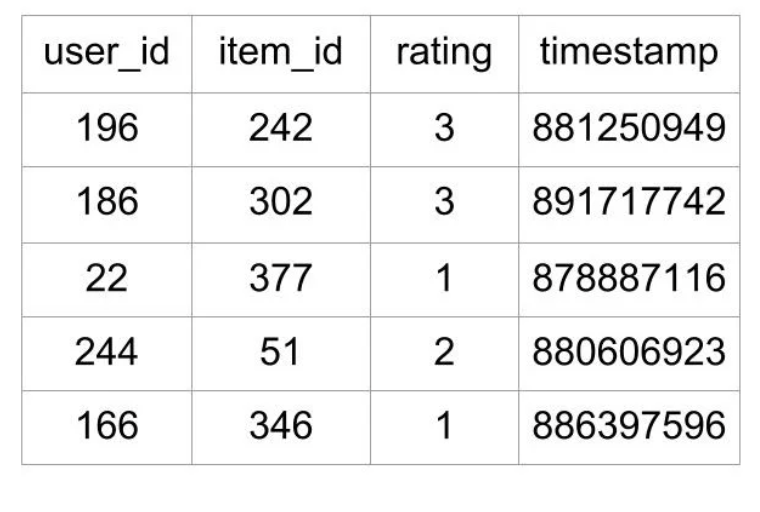

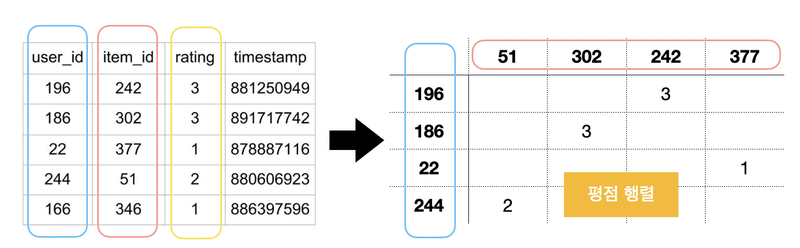

<br/>

> 위 데이터를 사용자간 아이템 간 `interaction matrix`로 변환한다. 우리는 이를 평점행렬이라 부른다. <br/>
>> 이러한 행렬을 실제 데이터로 만든다면 굉장히 sparse(희소)한 행렬이 만들어질 것이다. 대부분 평점에 대한 데이터는 **0**일 것이다.

<br/>

- **사용자 기반**, **아이템 기반**: 유사도를 계산하는 방식
- **잠재요인(latent factor)**: 행렬 인수분해(matrix factorization)를 이용해 잠재요인을 분석

### - 사용자 기반

> **당신과 비슷한 고객들**이 다음 상품을 구매했습니다.

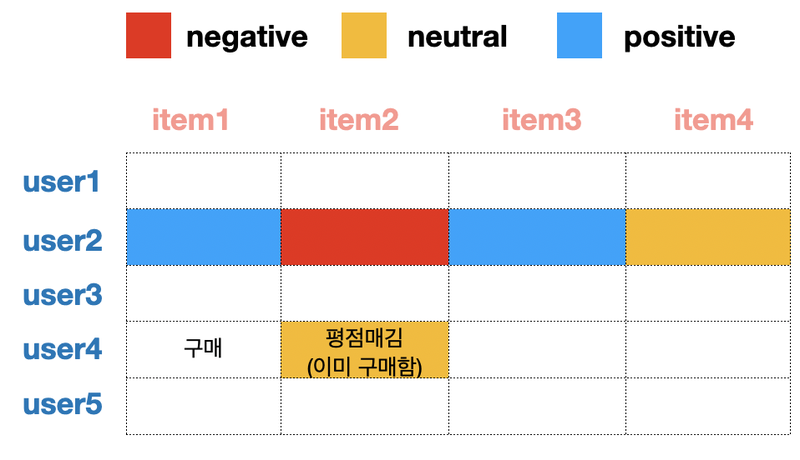

> User4가 item1을 구매했고, User4와 가장 유사한 User2는 item1~4까지 위와 같이 평점을 매겼다.
> - User2가 선호한 제품인 item3을 User4에게 추천해주자.

### - 아이템 기반
> **이 상품을 선택한 다른 고객들**은 다음 상품을 구매했습니다.

- 아이템 간의 유사도를 측정해 해당 아이템을 추천하는 방식으로, 사용자 기반보다 **정확도가 높다**고 한다.

> User2가 선호하는 item1이 있을 때, 그 아이템에 대한 다른 User들의 선호도를 조사한다.


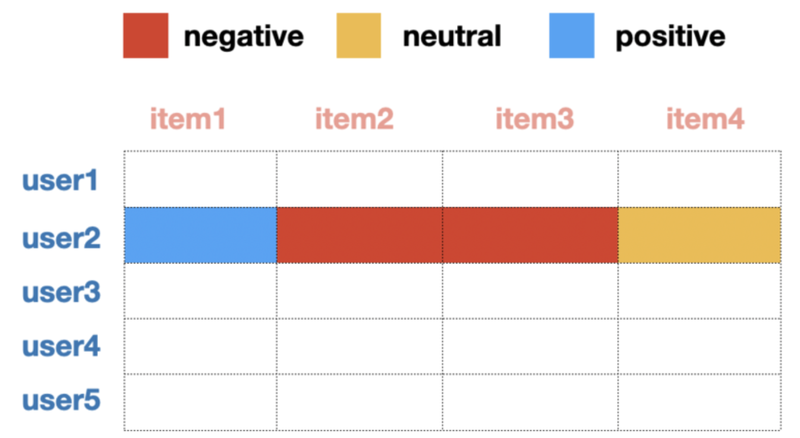

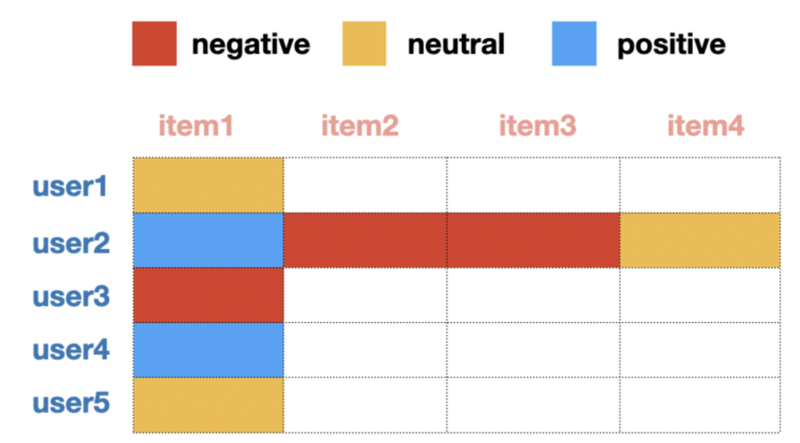
(User2의 item3에 대한 선호도는 'positive'이다.)

<br/>

> item1을 좋아하는 사람은 User4로, 그 User4에게 User2가 좋아한 상품인 item3을 추천해준다.

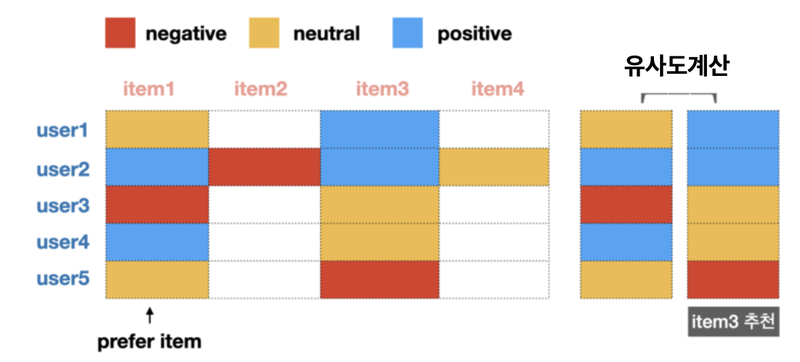

## 5. 협업 필터링 (2) 행렬 인수분해

잠재요인 협업 필터링은 평점행렬을 행렬 인수분해(matrix factorization)를 통해 잠재요인(latent factor)을 분석한다. <br/>

행렬 인수분해 기법들
- SVD (Singular Vector Decomposition)
- ALS (Alternating Least Squares)
- NMF (Non-Negative Factorization)

> 행렬을 분해하여 (분해 행렬) 사용하면 파라미터 수가 줄어들어 편리하다.

### SVD (Singular Vector Decomposition, 특이값 분해)

특잇값 분해는 임의의 `m x n` 형태의 행렬 `A`를 다음과 같은 형태로 분해하여 나타내는 방법이다.
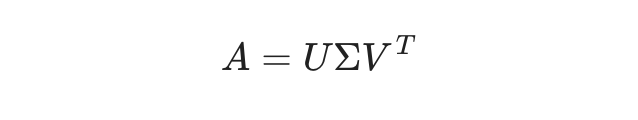

- $A$: m x n 행렬
- $U$: m x m 행렬
- $Σ$: m x n 행렬
- $V$: n x n 행렬

> 우리는 SVD라는 방법을 이용해 A라는 임의의 행렬을 여러 개의 A 행렬과 동일한 크기를 갖는 여러 개의 행렬로 분해해 생각할 수 있다.
> - SVD를 이용해 임의의 행렬 A를 정보량에 따라 여러 layer로 쪼개 생각할 수 있다!

<br/>

그림으로 표현하면 다음과 같다.
<br/>

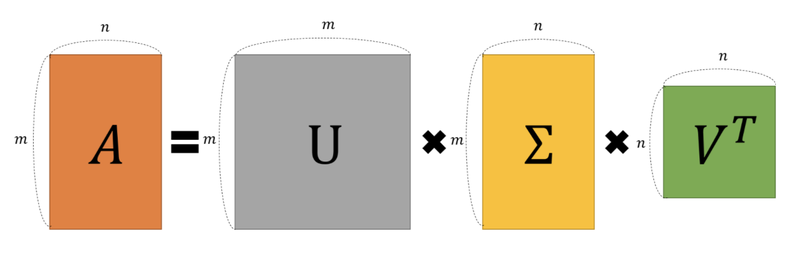

<br/>

> 특이값 분해는 분해되는 과정보단 분해된 행렬을 다시 조합하는 과정에서 그 응용력이 빛난다. 기존의 $U, Σ, V^T$로 분해되어 있던 A행렬을 특이값 p개만을 이용해 A'라는 행렬로 '부분 복원'할 수 있다.
> - 특이값의 크기에 따라 A의 정보량이 결정되기 때문에 값이 큰 몇 개의 특이값들을 가지고도 충분히 유용한 정보를 유지할 수 있다.

<br/>
<br/>

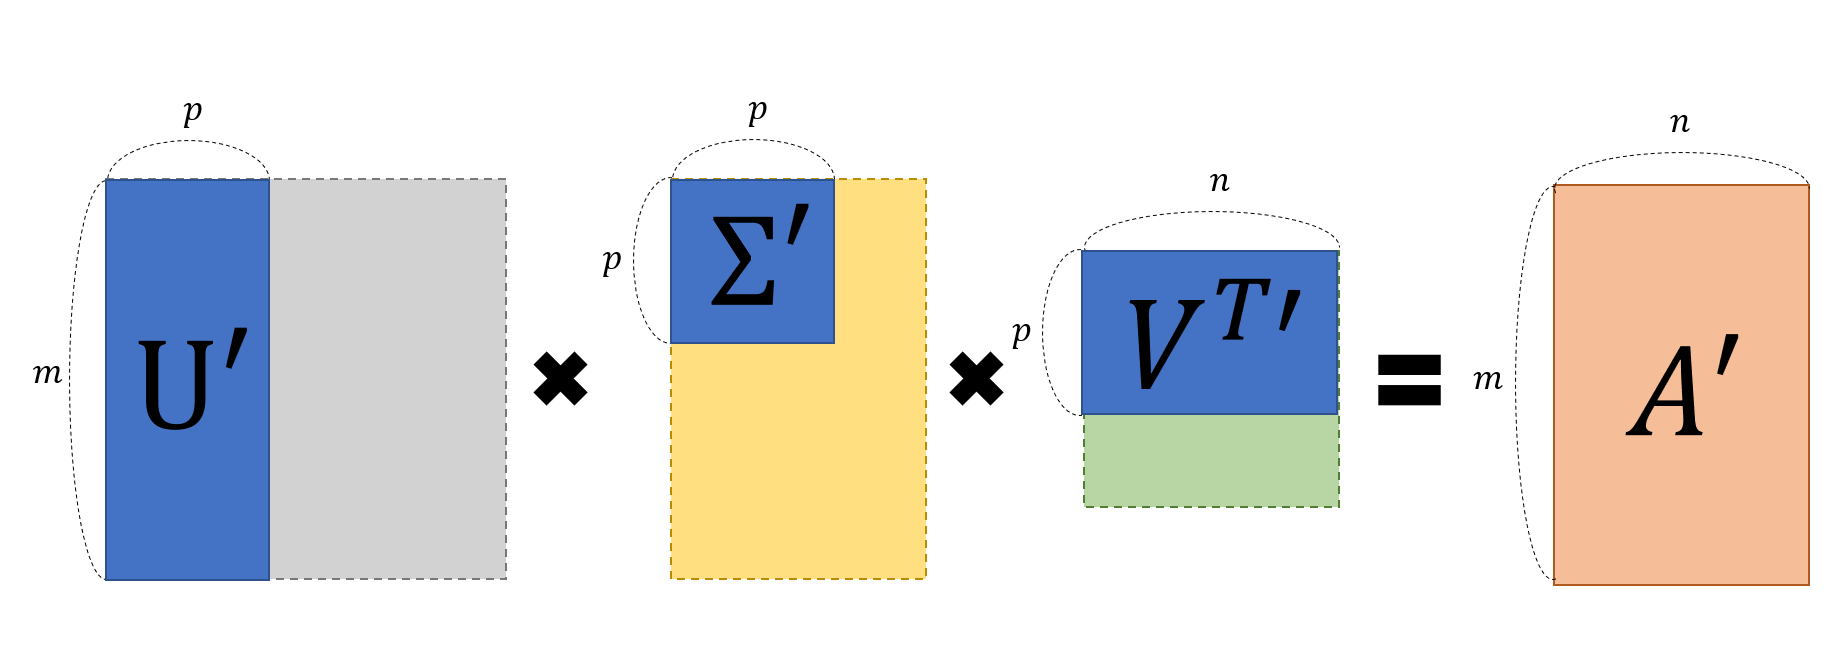

<br/>
(출처: https://angeloyeo.github.io/2019/08/01/SVD.html)


### SVD 실습
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

> `numpy.linalg`의 `svd` 모듈을 import한 후, `4x4` 형태의 행렬 A를 SVD하자.

In [81]:
import numpy as np
from numpy.linalg import svd

np.random.seed(30)
A = np.random.randint(0, 100, size=(4, 4))
A

array([[37, 37, 45, 45],
       [12, 23,  2, 53],
       [17, 46,  3, 41],
       [ 7, 65, 49, 45]])

In [82]:
svd(A)

(array([[-0.54937068, -0.2803037 , -0.76767503, -0.1740596 ],
        [-0.3581157 ,  0.69569442, -0.13554741,  0.60777407],
        [-0.41727183,  0.47142296,  0.28991733, -0.72082768],
        [-0.6291496 , -0.46389601,  0.55520257,  0.28411509]]),
 array([142.88131188,  39.87683209,  28.97701433,  14.97002405]),
 array([[-0.25280963, -0.62046326, -0.4025583 , -0.6237463 ],
        [ 0.06881225, -0.07117038, -0.8159854 ,  0.56953268],
        [-0.73215039,  0.61782756, -0.23266002, -0.16767299],
        [-0.62873522, -0.47775436,  0.34348792,  0.50838848]]))

> 결괏값으로 행렬 U, 행렬 Σ, 행렬 V^T가 생성된다.
> - 이 값들을 unpacking해서 각 변수명에 할당해주자.

In [83]:
U, Sigma, VT = svd(A)

print('U matrix: {}\n'.format(U.shape), U)
print('Sigma: {}\n'.format(Sigma.shape), Sigma)
print('V Transpose matrix: {}\n'.format(VT.shape), VT)

U matrix: (4, 4)
 [[-0.54937068 -0.2803037  -0.76767503 -0.1740596 ]
 [-0.3581157   0.69569442 -0.13554741  0.60777407]
 [-0.41727183  0.47142296  0.28991733 -0.72082768]
 [-0.6291496  -0.46389601  0.55520257  0.28411509]]
Sigma: (4,)
 [142.88131188  39.87683209  28.97701433  14.97002405]
V Transpose matrix: (4, 4)
 [[-0.25280963 -0.62046326 -0.4025583  -0.6237463 ]
 [ 0.06881225 -0.07117038 -0.8159854   0.56953268]
 [-0.73215039  0.61782756 -0.23266002 -0.16767299]
 [-0.62873522 -0.47775436  0.34348792  0.50838848]]


> 잘 분해가 된 것을 확인할 수 있고, 다시 복원해보자.
> - 복원을 위해선 U, Σ, V^T를 내적하자.
> - 여기서 Σ는 1차원이기 때문에, 0을 포함한 대각 행렬로 변환한 뒤 내적을 해줘야 한다.

In [87]:
Sigma

array([142.88131188,  39.87683209,  28.97701433,  14.97002405])

In [88]:
np.diag(Sigma)

array([[142.88131188,   0.        ,   0.        ,   0.        ],
       [  0.        ,  39.87683209,   0.        ,   0.        ],
       [  0.        ,   0.        ,  28.97701433,   0.        ],
       [  0.        ,   0.        ,   0.        ,  14.97002405]])

In [84]:
Sigma_mat = np.diag(Sigma)

A_ = np.dot(np.dot(U, Sigma_mat), VT)
A_

array([[37., 37., 45., 45.],
       [12., 23.,  2., 53.],
       [17., 46.,  3., 41.],
       [ 7., 65., 49., 45.]])

### Truncated SVD

추천 시스템에서의 행렬 인수분해는 SVD 중에서도 Truncated SVD를 사용한다.
> '잘린 SVD', 다른 말론 LSA(Latent semantic analysis, 잠재 의미 분석)이라 번역한다.
> - Truncated SVD를 이용해 분해를 한 뒤 복원하면 SVD처럼 완벽히 같은 행렬이 나오진 않는데, 그 이유는 Truncated SVD가 차원을 축소한 뒤 행렬을 분해하기 때문이다.

- 사이킷런에서는 `TruncatedSVD` 기능을 함수로 제공해준다.
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

<br/>

> (+) Σ 행렬에 있는 상위 일부 원소만 추출해 분석하는 방식이다.
> - 이렇게 분해하면 인위적으로 더 작은 U, Σ, V^T로 분해하기 때문에 데이터가 소실되어 원본 행렬을 정확하게 다시 복원할 수 없다.

## 6. 협업 필터링 (3) 행렬 인수분해와 잠재요인 협업 필터링

> SVD(특이값 분해)를 평가행렬에 적용하여 잠재요인을 분석하는 것을 도식화한 그림이다.

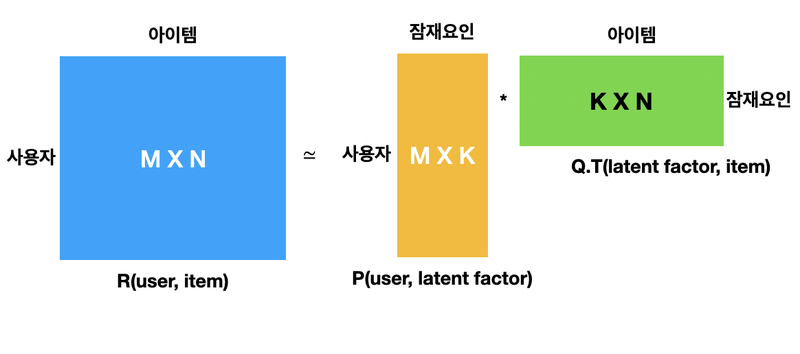

<br/>

- R: 사용자 & 아이템 간의 행렬
- P: 사용자 & 잠재요인 간의 행렬
- Q: 아이템 & 잠재요인 간의 행렬 -> 전치 행렬 형태로 나타냄

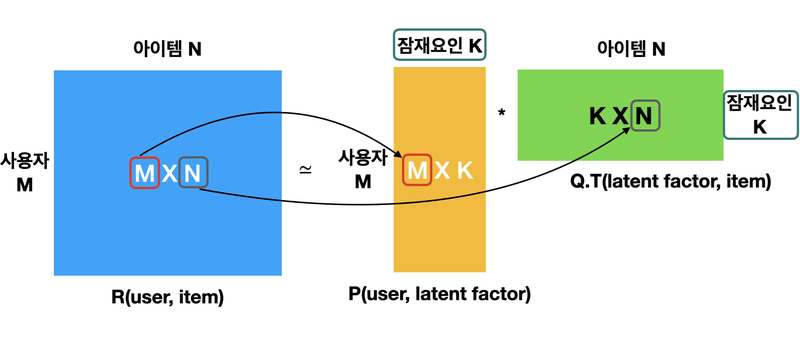


<br/>

사용자가 아이템에 대한 평점을 매기는 요인에는 많은 항목이 있을텐데, 주관적이기도 할 것이다. 그렇기에 이를 '잠재요인'으로 취급한 뒤 이를 SVD 기법을 이용해 분해한 뒤 다시 합치는 방식으로 영화에 평점을 매긴 이유를 벡터화하여 이를 기반으로 추천한다.


> 협업 필터링을 이용해 사용자가 아이템에 대해 평점을 매긴 `평점행렬`을 행렬 인수분해(Matrix Factorization)를 통해 `잠재요인`을 분석한 뒤 `유사도`를 계산할 수도 있고, `사용자의 평점도 예측`할 수 있다.

## 7. 실제 추천 시스템

사용자의 구매 여부와 평점 데이터 뿐만 아니라 얼마나 오랜 시간동안 시청(웹 사이트에 머물렀는지), 어떤 사이트에서 유입되었는지, 시청한 뒤 구매로 이어지기까지의 시간 등 다양한 요인들을 분석한다.
> 이를 Digital Footprint(디지털 발자국), Digital Shadow(디지털 그림자)라고 한다.

그 중 가장 중요한 지표는 **클릭률**인데, 전문 용어로는 **CTR(Click Through Rate)**이다. <br/>

이러한 데이터들을 모두 모아 추천한 뒤, 해당 아이템이 적절한 추천인지 여부를 평가하는 것도 중요한 일이다. 추천한 제품이 구매로 이어졌는지를 통해 추천에 성공했는지를 평가하거나 모델 단계에서 평가하기도 한다. <br/>

> 추천 시스템에 머신러닝이 적용될 수도 있는 것이지 머신러닝 안에 추천 시스템이 있는 것은 결코 아니다.